## 创建一个llava模型

1. 需要设置`<image>`这个token id，从前qwen因为embed是一个列表的数字，现在需要调整为一个
2. 需要设置pad_token_id
3. 将clip模型的vision_model模块进行提取
4. 将language_model模块进行提取
5. 相关文件赋值

### 下载好模型
pip install -U huggingface_hub

从huggingface中下载vision model and language model

huggingface-cli download "huggingface模型地址" --local-dir "自定义文件夹名称" --local-dir-use-symlinks False

huggingface-cli download Qwen/Qwen1.5-4B-Chat --local-dir Qwen1.5-4B-Chat --local-dir-use-symlinks False

openai/clip-vit-large-patch14-336

### 修改qwen的tokenizer相关文件：设置`<image>`的token_id

1. 在`tokenizer_config.json`文件里面的`added_tokens_decoder`里面，添加一个id
```json
"151646": {
    "content": "<image>",
    "lstrip": false,
    "normalized": false,
    "rstrip": false,
    "single_word": false,
    "special": true
    }
```

2. 在`tokenizer_config.json`文件里面`additional_special_tokens`里面加上`"<iamge>"`

### 验证一下原版千问的image id

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

modify_qwen_tokenizer_dir = "/home/yujiaxi/DLModels/llavalearn/Qwen2.5-0.5B"
modify_qwen_tokenizer = AutoTokenizer.from_pretrained(modify_qwen_tokenizer_dir)

modify_qwen_tokenizer.encode("<image>")

c:\Users\student\anaconda3\envs\LLM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[151646]

Q:加了新的token，一般需要修改模型的embedding模块
A:在这里不需要，因为qwen_model.model.embed_tokens预留了足够的空间

In [2]:
len(modify_qwen_tokenizer)

151647

In [3]:
qwen_model = AutoModelForCausalLM.from_pretrained(
    modify_qwen_tokenizer_dir, device_map="cuda:0", torch_dtype=torch.bfloat16
)

In [4]:
(qwen_model.model.embed_tokens,)

(Embedding(151936, 1024),)

In [5]:
qwen_model.lm_head

Linear(in_features=1024, out_features=151936, bias=False)

## 重启开始进行初始化

### llava模型初始化

In [ ]:
clip_model_name_or_path = (
    "/home/yujiaxi/DLModels/llavalearn/openai/clip-vit-large-patch14-336"
)
qwen_model_name_or_path = "/home/yujiaxi/DLModels/llavalearn/Qwen2.5-0.5B"

In [7]:
from transformers import AutoModel, AutoModelForCausalLM, AutoTokenizer, AutoProcessor

clip_model = AutoModel.from_pretrained(clip_model_name_or_path, device_map="cuda:0")
llm_model = AutoModelForCausalLM.from_pretrained(
    qwen_model_name_or_path, device_map="cuda:0"
)

In [8]:
llm_tokenizer = AutoTokenizer.from_pretrained(qwen_model_name_or_path)
llm_tokenizer.encode("<image>")

[151646]

In [9]:
from transformers import LlavaForConditionalGeneration, LlavaConfig

## 将clip模型和llm_model模型的config拿出来，初始化一个llava model

In [10]:
# Initializing a CLIP-vision config
vision_config = clip_model.vision_model.config

# Initializing a llm config
text_config = llm_model.config

# Initializing a llava-1.5-7b style configuration
configuration = LlavaConfig(vision_config, text_config)

# Initializing a model from the llava-1.5-7b style configuration
model = LlavaForConditionalGeneration(configuration)

In [11]:
model.vision_tower.vision_model.embeddings

CLIPVisionEmbeddings(
  (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
  (position_embedding): Embedding(577, 1024)
)

In [12]:
clip_model.vision_model.embeddings

CLIPVisionEmbeddings(
  (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
  (position_embedding): Embedding(577, 1024)
)

上面只是将llava的形状初始化，模型权重还是随机生成的，需要将两个模型的权重复制过去

In [13]:
model.vision_tower.vision_model = clip_model.vision_model

In [14]:
model.language_model = llm_model

In [15]:
llm_model.model.embed_tokens.weight.data[:, :2]

tensor([[ 0.0576,  0.0140],
        [ 0.0645, -0.0425],
        [ 0.0242,  0.0090],
        ...,
        [-0.0320,  0.0036],
        [-0.0320,  0.0037],
        [-0.0320,  0.0036]], device='cuda:0')

In [16]:
model.language_model.model.embed_tokens.weight.data[:, :2]

tensor([[ 0.0576,  0.0140],
        [ 0.0645, -0.0425],
        [ 0.0242,  0.0090],
        ...,
        [-0.0320,  0.0036],
        [-0.0320,  0.0037],
        [-0.0320,  0.0036]], device='cuda:0')

复制pad_token_id

In [17]:
model.config.pad_token_id

In [18]:
model.config.pad_token_id = llm_tokenizer.pad_token_id
model.config.pad_token_id

151643

复制image_token_index

In [19]:
model.config.image_token_index

32000

In [20]:
llm_tokenizer.encode("<image>")[0]

151646

In [21]:
model.config.image_token_index = llm_tokenizer.encode("<image>")[0]
model.config.image_token_index

151646

保存模型

In [22]:
model.save_pretrained("show_model/model001")

保存processor

In [23]:
llm_tokenizer.save_pretrained("show_model/model001")

('show_model/model001\\tokenizer_config.json',
 'show_model/model001\\special_tokens_map.json',
 'show_model/model001\\vocab.json',
 'show_model/model001\\merges.txt',
 'show_model/model001\\added_tokens.json',
 'show_model/model001\\tokenizer.json')

In [24]:
autoprocessor = AutoProcessor.from_pretrained(clip_model_name_or_path)
autoprocessor.save_pretrained("show_model/model002")

[]

注意：
1. 需要把show_model/model002中的preprocessor_config.json文件放到show_model/model001中

## 重启开始测试效果

In [1]:
from transformers import LlavaProcessor, LlavaForConditionalGeneration
import torch

model_name_or_path = "show_model/model001"

llava_processor = LlavaProcessor.from_pretrained(model_name_or_path)
model = LlavaForConditionalGeneration.from_pretrained(
    model_name_or_path, device_map="cuda:0", torch_dtype=torch.bfloat16
)

c:\Users\student\anaconda3\envs\LLM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from PIL import Image

prompt_text = "<image>\nWhat are these?"

messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": prompt_text},
]
prompt = llava_processor.tokenizer.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

image_path = "wallhaven-m373o9_1280x800.png"
image = Image.open(fp=image_path)

inputs = llava_processor(text=prompt, images=image, return_tensors="pt")

for tk in inputs.keys():
    inputs[tk] = inputs[tk].to(model.device)
generate_ids = model.generate(**inputs, max_new_tokens=50)
gen_text = llava_processor.batch_decode(
    generate_ids, skip_special_tokens=False, clean_up_tokenization_spaces=False
)[0]

print(gen_text)

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
c:\Users\student\anaconda3\envs\LLM\lib\site-packages\transformers\models\clip\modeling_clip.py:491: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to th

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<image>
What are these?<|im_end|>
<|im_start|>assistant
These are scientific and technical terms related to the field of astronomy. They describe the properties and behavior of celestial bodies, such as planets, stars, and galaxies. The terms are used in various fields, such as astrophysics, astronomy, and space


In [5]:
print(prompt)

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<image>
What are these?<|im_end|>
<|im_start|>assistant



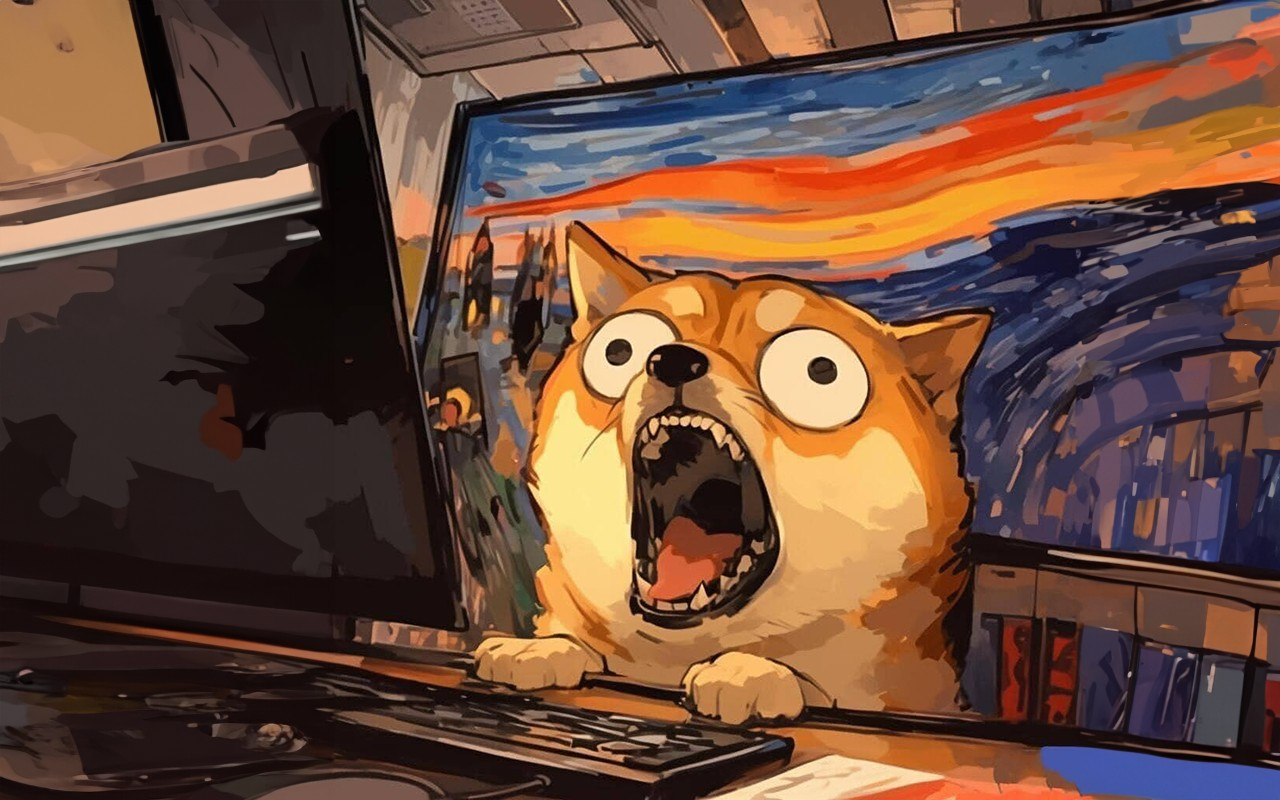

In [3]:
image